In [2]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
# import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import cmocean.cm as cmo
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
plotsdir = lambda x: "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/paper_figures/" + x
obsdatadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/observations/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/yearly_output_0.25deg/" + x

In [4]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores = 36, 
    processes=1,
    memory='125GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=10)
from dask.distributed import Client
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=117G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.131:37821 --name dummy-name --nthreads 36 --memory-limit 116.42GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.131:37821,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [7]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr", 
        chunks = {"time":1})
    
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds = ds.where(ds.thkcello > 1e-9)
    ds = ds[["cfc11", "thkcello", "z"]]
    return ds

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")
ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))
ds_ctrl = read_CM4X(datadir("CM4Xp125_piControl_transient_tracers.zarr"))
ds_ctrl = ds_ctrl.isel(year = slice(None, 165))
ds_ctrl.coords['year'] = ds_ctrl.time.values

ds = ds.sel(year = slice(1990, 2014))
ds_ctrl = ds_ctrl.sel(year = slice(1990, 2014))

OSError: no files to open

In [ ]:
# ds_ctrl = get_sigma2(ds_ctrl)
# ds = get_sigma2(ds)

In [ ]:
def weighted_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

water_mass_mask = lambda ds: ds.where((ds.lat < -40) * (ds.sigma2 >=37.))

def volume_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh", "zl"]) / weights.sum(["xh", "yh", "zl"])
    return weighted_ds
    

In [ ]:
glodap_gridded = xr.open_mfdataset(obsdatadir("GLODAP_gridded.nc")).sel(time = slice(1990, 2014))
area=np.cos(np.radians(abs(glodap_gridded.lat)))*(111.1*111.1*1000*1000)
AREA, _ = np.meshgrid(area, glodap_gridded.lon)
glodap_gridded["area"] = (("lon", "lat"), AREA)

glodap_gridded_var = glodap_gridded[["G2cfc11", "area"]]

glodap_gridded_var["mask"] = xr.where(~np.isnan(glodap_gridded_var["G2cfc11"]), 1, np.nan)
glodap_gridded_var["area_mask"] = glodap_gridded_var["mask"] * glodap_gridded_var["area"]
glodap_gridded_var.coords['time'] = ds.year.values
glodap_gridded_var = glodap_gridded_var.rename({'time':'year'})

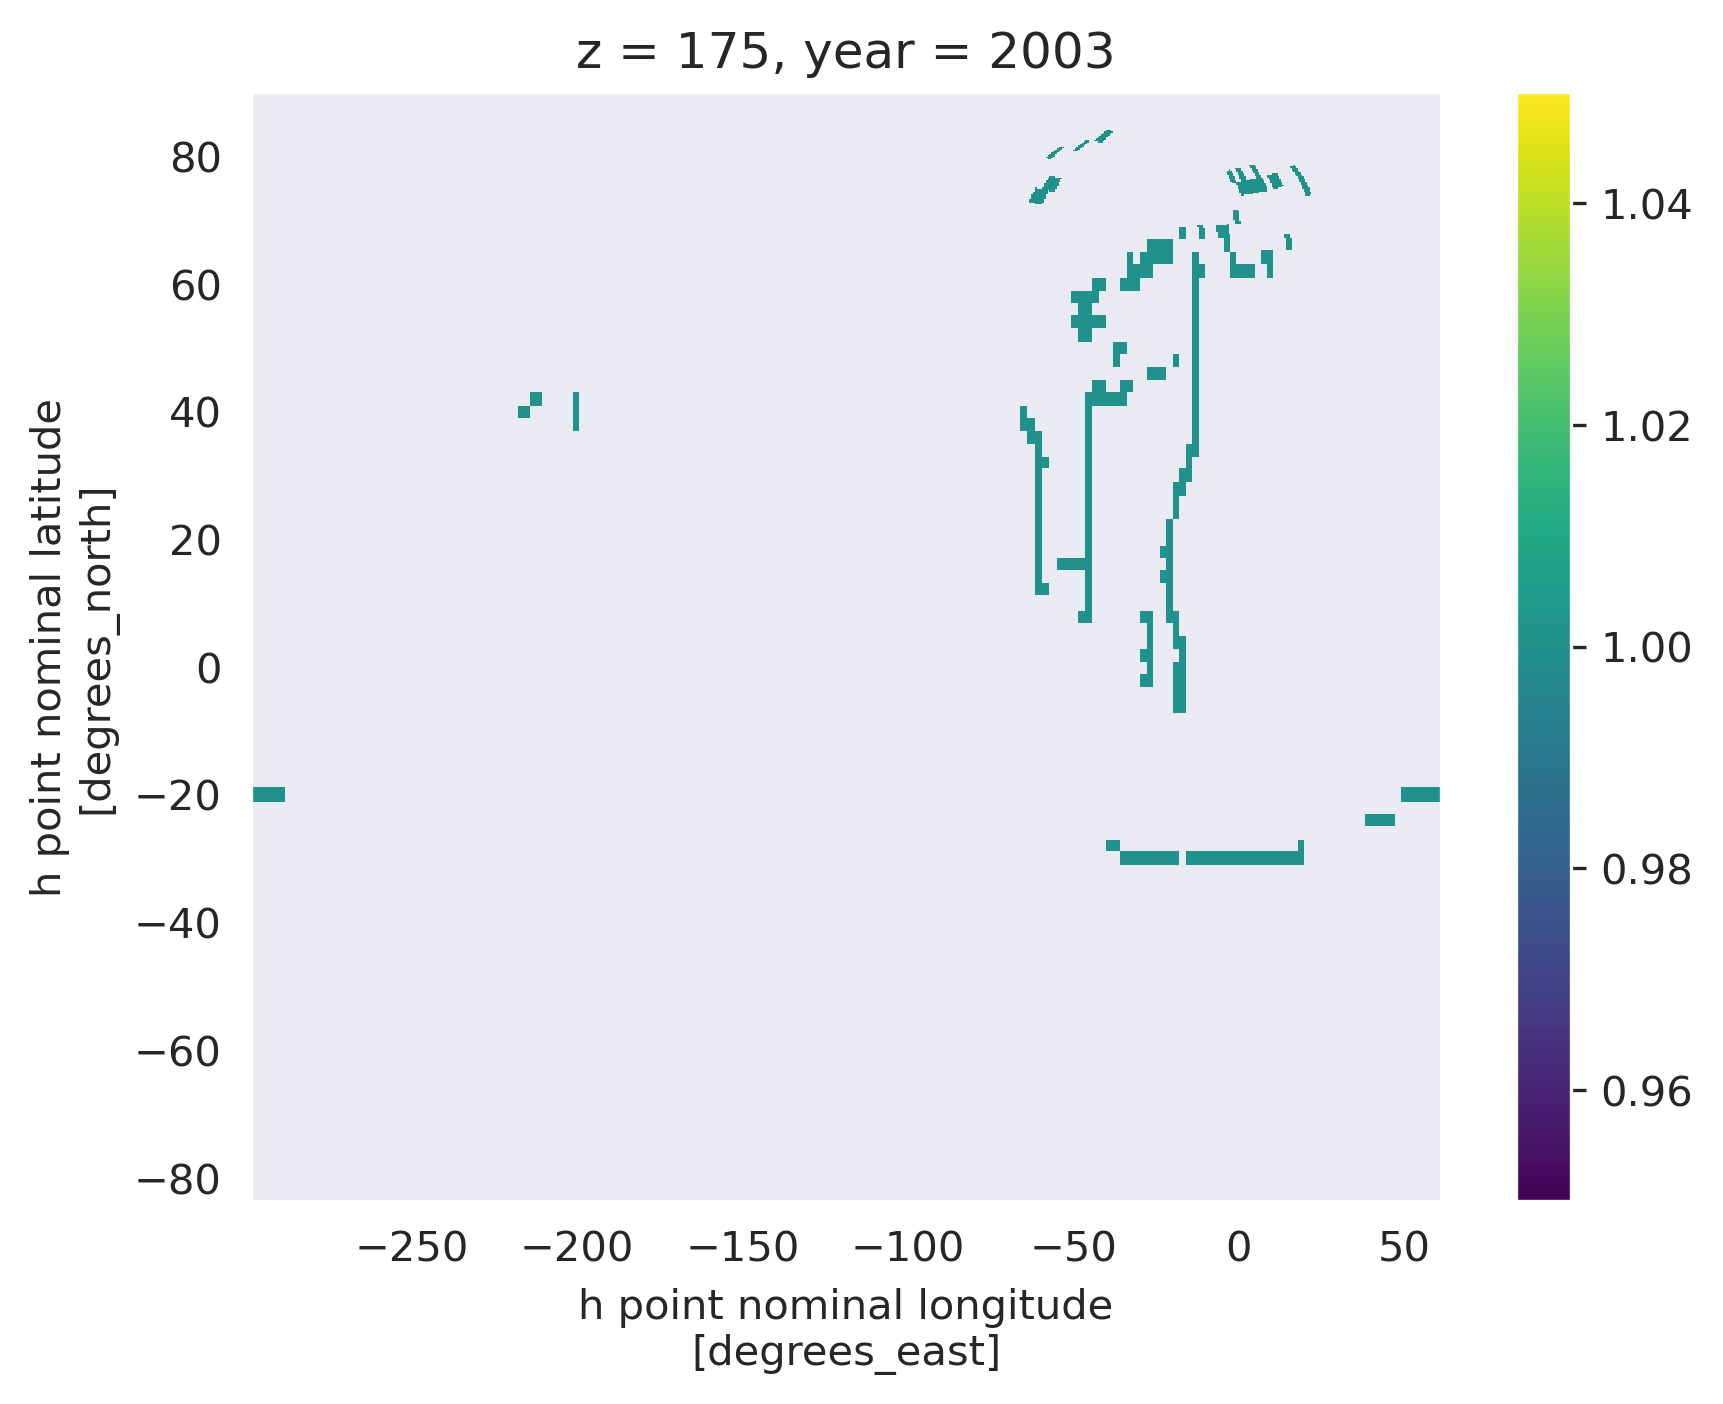

In [13]:
regridder = xe.Regridder(glodap_gridded_var["mask"], ds, "nearest_s2d")
glodap_mask = regridder(glodap_gridded_var["mask"])
# glodap_mask.sel(time = 
glodap_mask.sel(year = 2003, z = 175).plot()

In [62]:
glodap_mask.where((glodap_mask.lon > -60) * (glodap_mask.lon < -30)).isel(z = 20).sum(["xh", "yh"]).compute()

<xarray.DataArray (year: 25)> Size: 200B
array([ 440.,  694., 1044., 1410., 2048., 1874., 1084., 2740., 1048.,
       1408.,  676., 1176.,  782., 1754.,  978., 1618.,  512.,  339.,
          0.,  148., 1092., 1070.,  770.,  296.,  630.])
Coordinates:
    z        int64 8B 1600
  * year     (year) int64 200B 1990 1991 1992 1993 1994 ... 2011 2012 2013 2014

In [61]:
glodap_mask.where((glodap_mask.lon > -60) * (glodap_mask.lon < -30)).isel(z = 25).sum(["xh", "yh"]).compute()

<xarray.DataArray (year: 25)> Size: 200B
array([ 440.,  634., 1020., 1410., 2000., 1874., 1084., 2590., 1048.,
       1390.,  676., 1062.,  714., 1736.,  942., 1558.,  512.,  339.,
          0.,  148., 1060., 1050.,  710.,  296.,  630.])
Coordinates:
    z        int64 8B 1975
  * year     (year) int64 200B 1990 1991 1992 1993 1994 ... 2011 2012 2013 2014

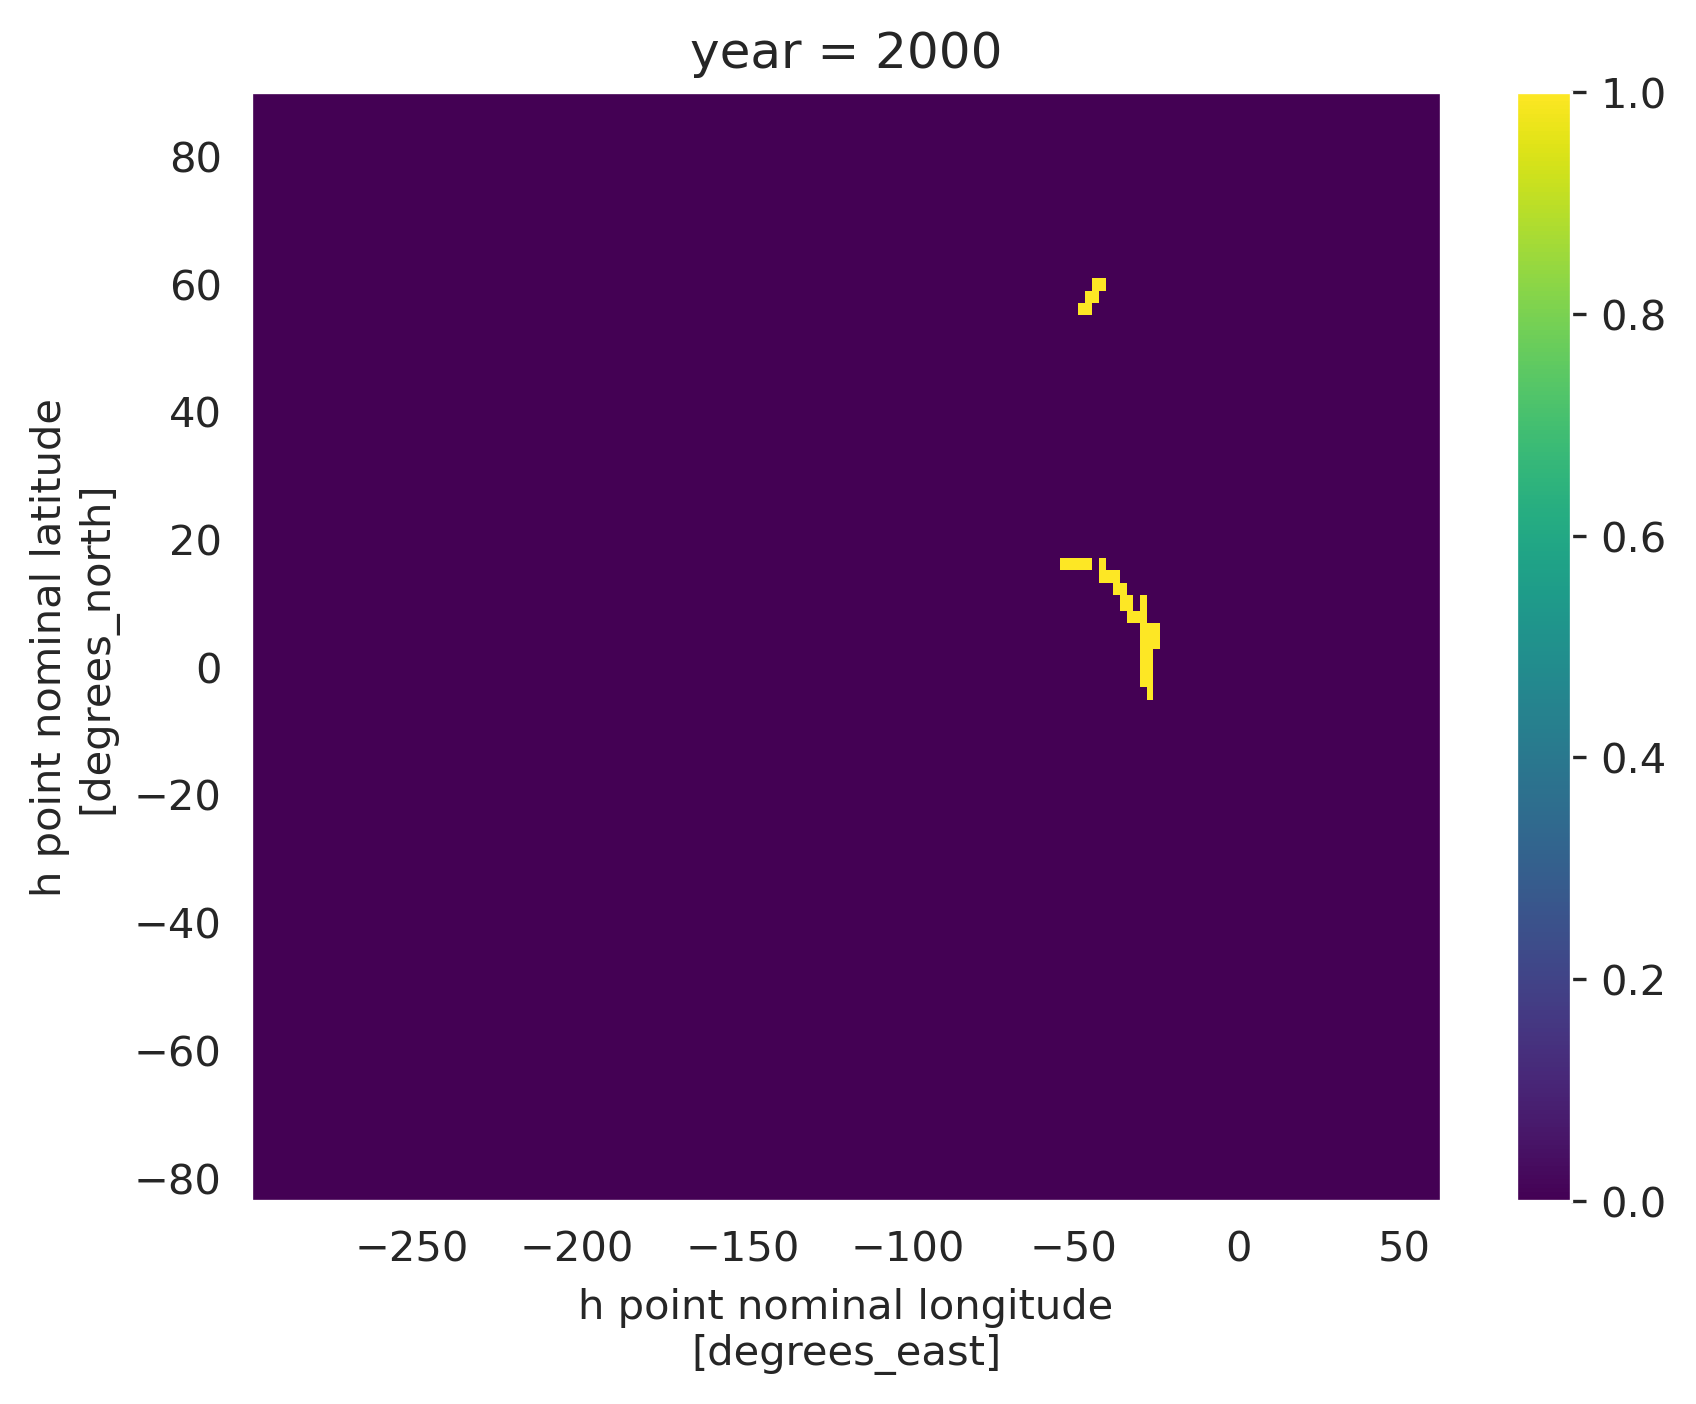

In [72]:
.isel(year = 10).plot()

In [79]:
glodap_cond = (glodap_mask.isel(z = 35) == 1) * (glodap_mask.lon > -60) * (glodap_mask.lon < -30) * (glodap_mask.lat < -40)
glodap_cond = glodap_cond.drop("z")

/tmp/ipykernel_182123/714993344.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  glodap_cond = glodap_cond.drop("z")


In [80]:
ds_ctrl_masked = weighted_average(ds_ctrl * glodap_cond).compute()

ds_masked = weighted_average(ds * glodap_cond).compute()

/tmp/ipykernel_182123/546022322.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 10.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tmp/ipykernel_182123/546022322.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])


In [85]:
interp_ctrl_timeseries = interpolate_section(ds_ctrl_masked, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_hist_timeseries = interpolate_section(ds_masked, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")

In [91]:
glodap_so = glodap_gridded_var.where((glodap_gridded_var.lon > -60) * (glodap_gridded_var.lon < -30) * (glodap_gridded_var.lat < -40))

glodap_so_avg = (glodap_so["G2cfc11"] * glodap_so["area_mask"]).sum(["lat", "lon"])
glodap_so_avg = glodap_so_avg / glodap_so["area_mask"].sum(["lat", "lon"])
glodap_so_avg

<xarray.DataArray (year: 25, z: 79)> Size: 16kB
dask.array<truediv, shape=(25, 79), dtype=float64, chunksize=(25, 79), chunktype=numpy.ndarray>
Coordinates:
  * z        (z) int64 632B 100 175 250 325 400 475 ... 5650 5725 5800 5875 5950
  * year     (year) int64 200B 1990 1991 1992 1993 1994 ... 2011 2012 2013 2014

### try plotting the raw data 

<xarray.DataArray 'cfc11' ()> Size: 8B
array(5.39835485)


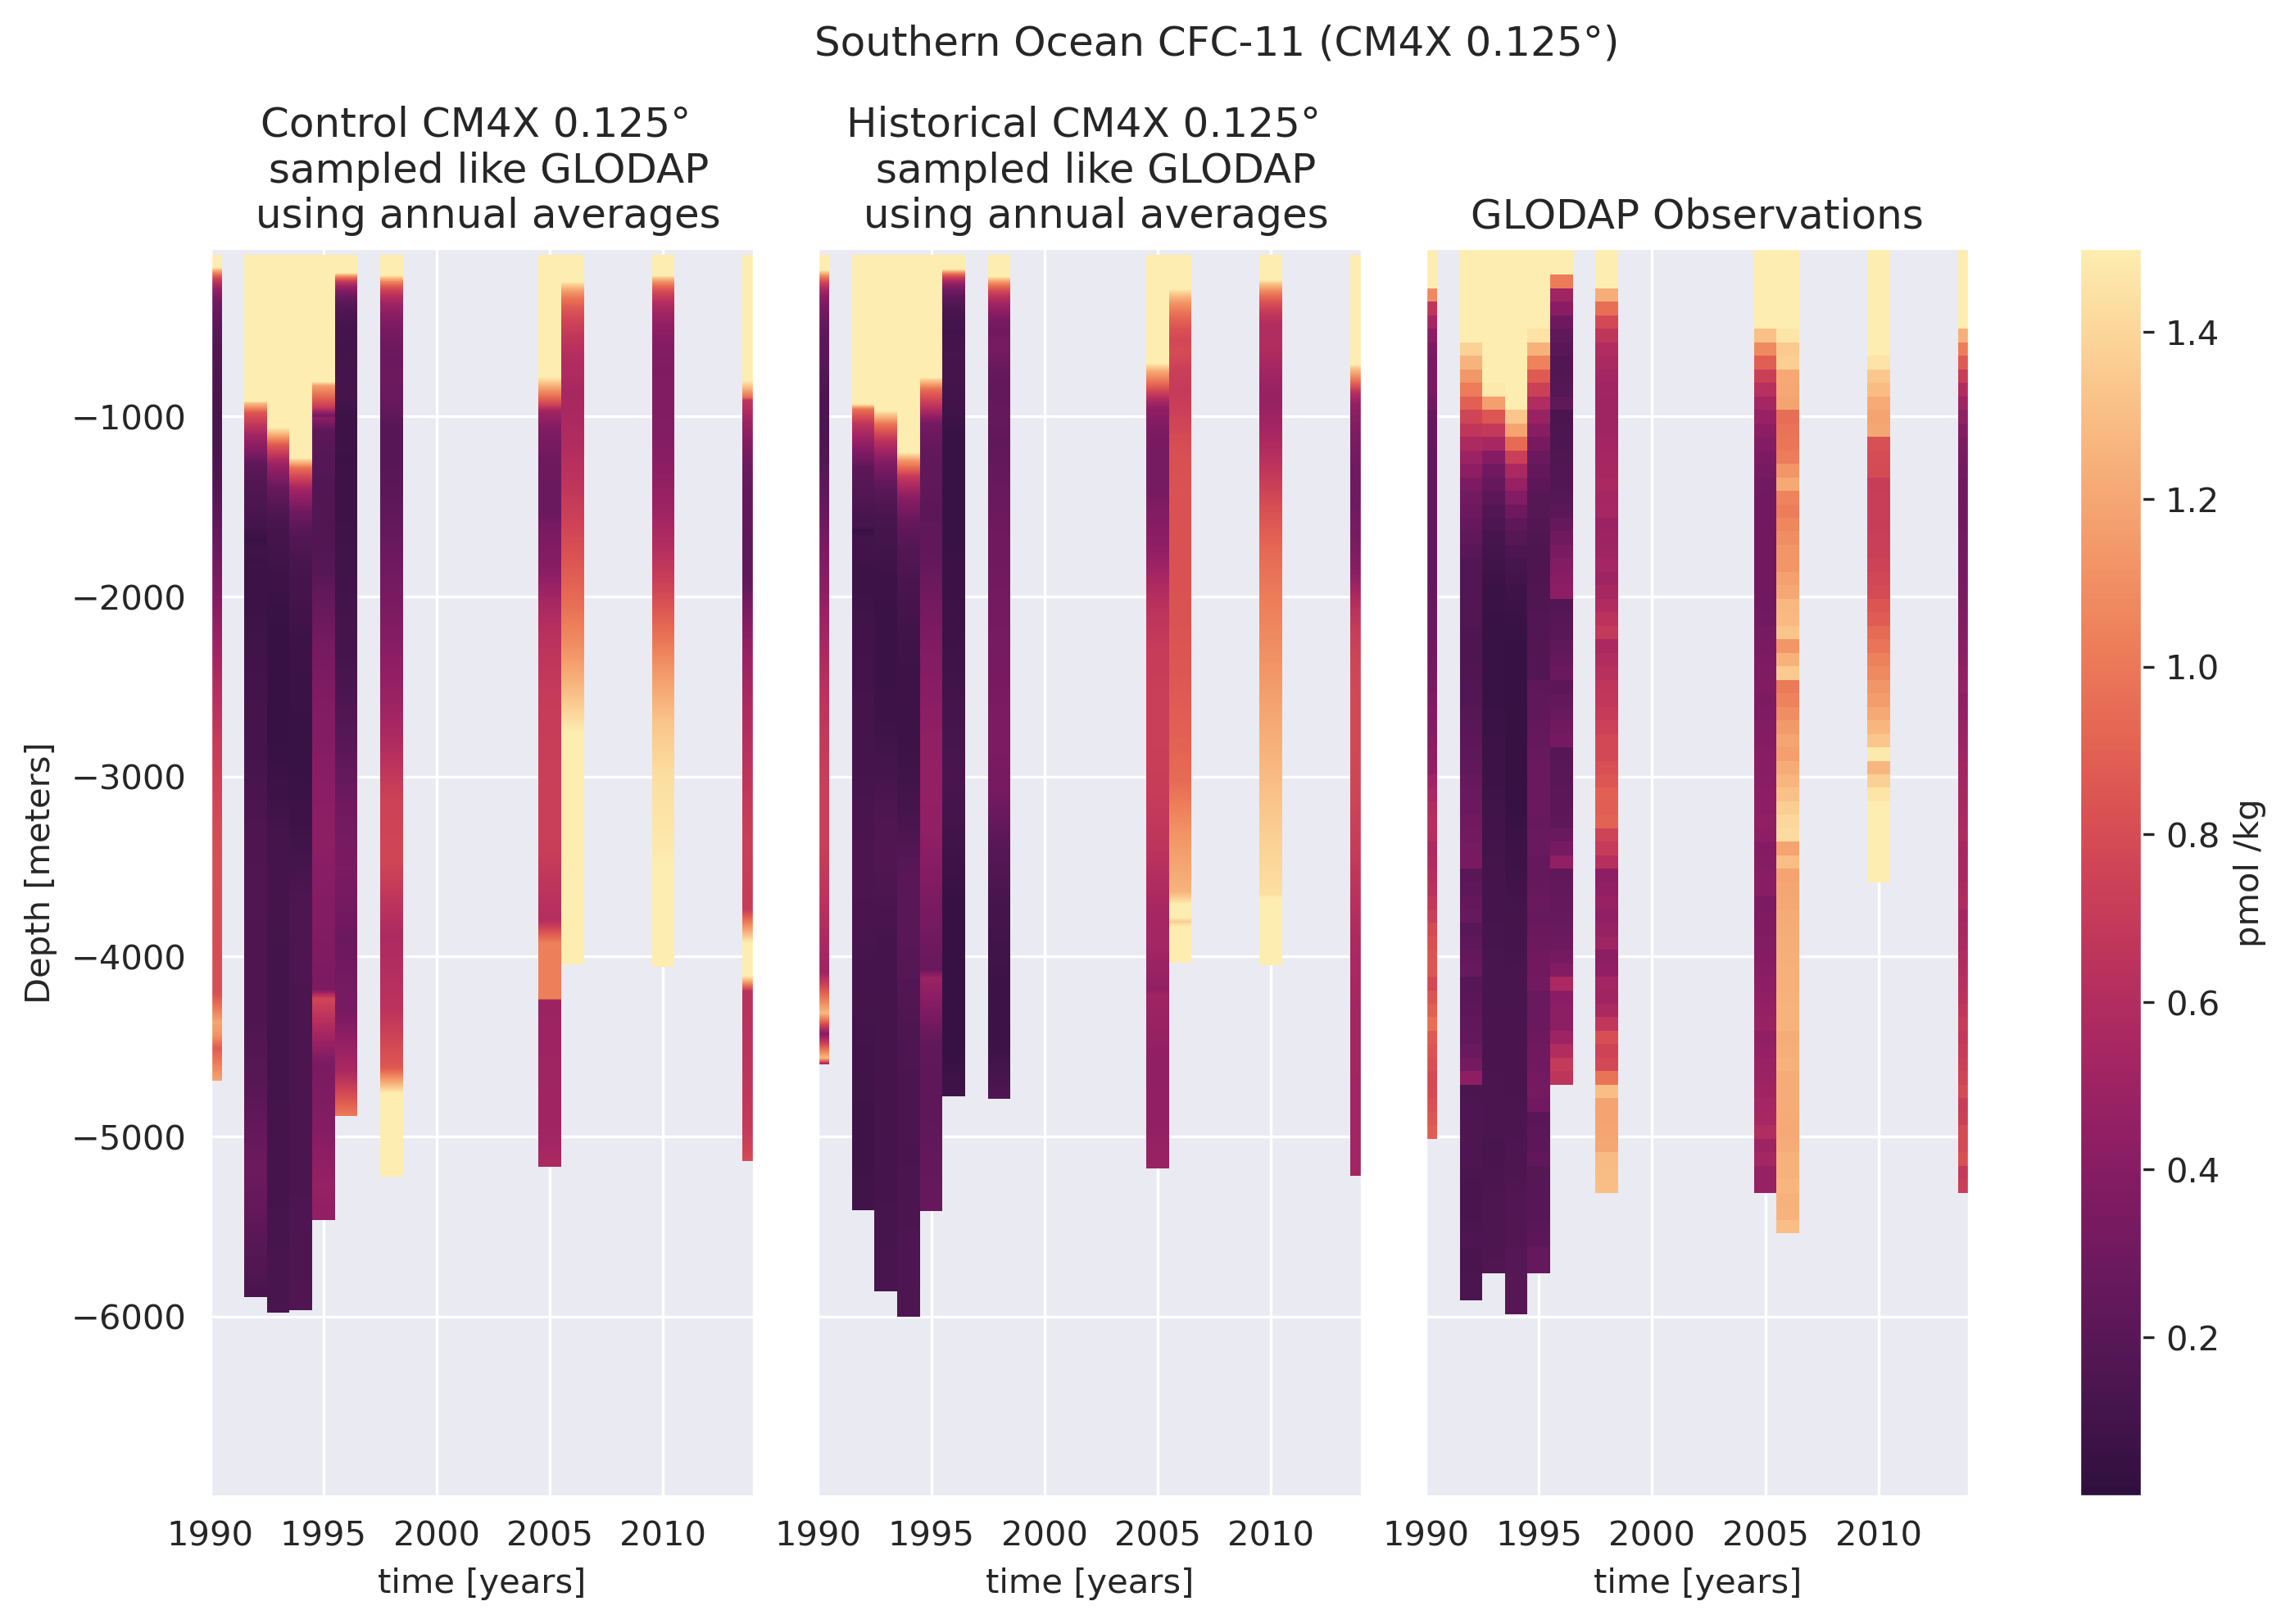

In [111]:
fig, ax = plt.subplots(1, 3, figsize = (10, 6.5), sharey = True)

tracername = "CFC-11"
tmp1 = interp_ctrl_timeseries.cfc11 * variable_kwargs["cfc11"]["conversion"]
tmp1 = tmp1.where(tmp1 > 0)
print(tmp1.max())
ax[0].pcolormesh(interp_ctrl_timeseries.year, tmp1.z, tmp1, vmax = 1.5, vmin = 1e-2, cmap = cmo.matter_r)
ax[0].set_xlim(1990, 2014)
ax[0].set_title("Control CM4X 0.125° \n sampled like GLODAP\n using annual averages")
ax[0].set_ylabel("Depth [meters]")

tmp2 = interp_hist_timeseries.cfc11  * variable_kwargs["cfc11"]["conversion"]
tmp2 = tmp2.where(tmp2 > 0)
cm = ax[1].pcolormesh(interp_hist_timeseries.year, tmp2.z, tmp2, vmax = 1.5, vmin = 1e-2, cmap = cmo.matter_r)

ax[1].set_xlim(1990, 2014)
ax[1].set_title("Historical CM4X 0.125° \n sampled like GLODAP\n using annual averages")

tmp3 = glodap_so_avg.T
cm1 = ax[2].pcolormesh(tmp3.year, -tmp3.z, tmp3,  vmax = 1.5, vmin = 1e-2, cmap = cmo.matter_r)
ax[2].set_xlim(1990, 2014)
ax[2].set_title("GLODAP Observations")

fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")
fig.tight_layout()
fig.colorbar(cm, ax = ax[0:3], label = "pmol /kg")

for a in ax[0:3]:
    a.set_xlabel("time [years]")


### try plotting the interpolated data 

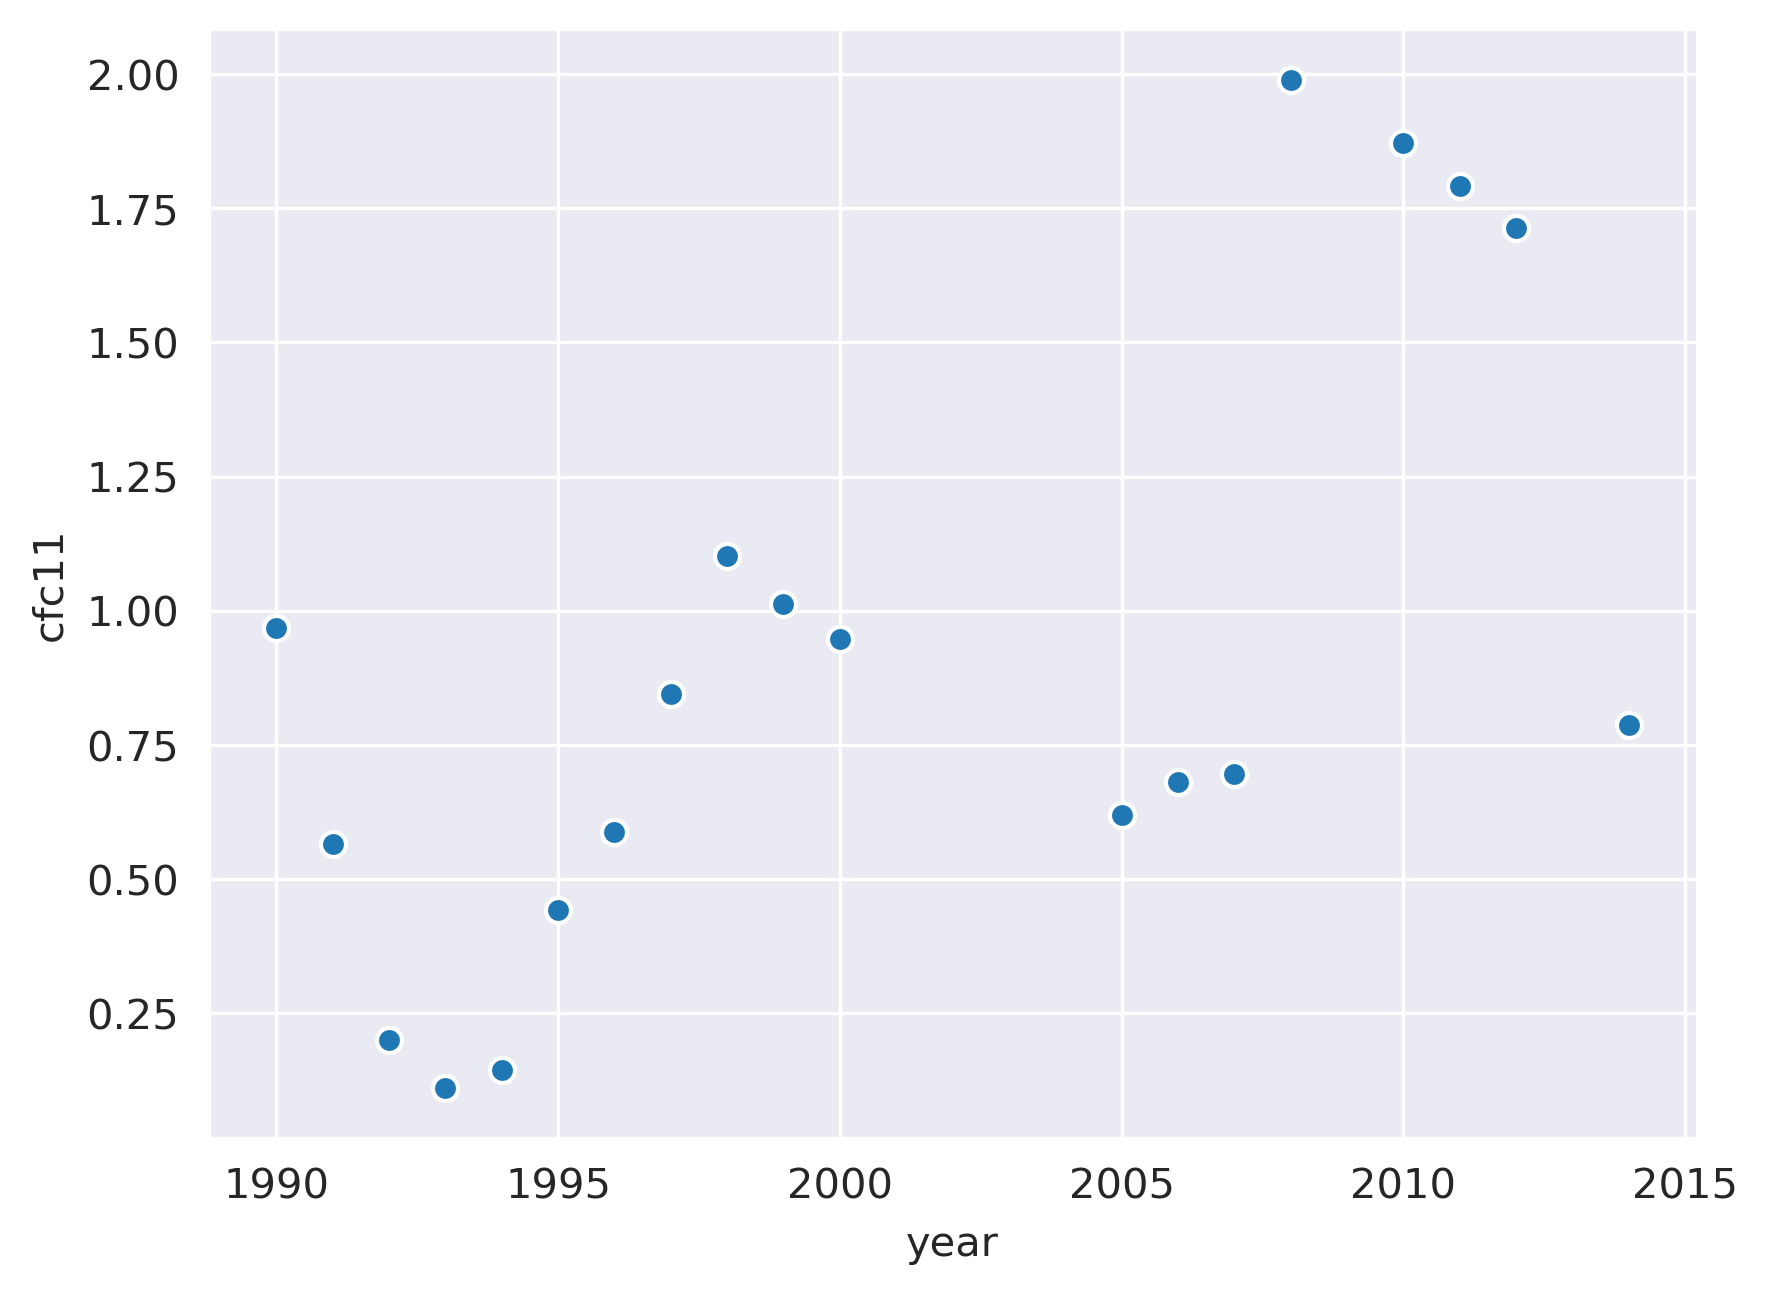

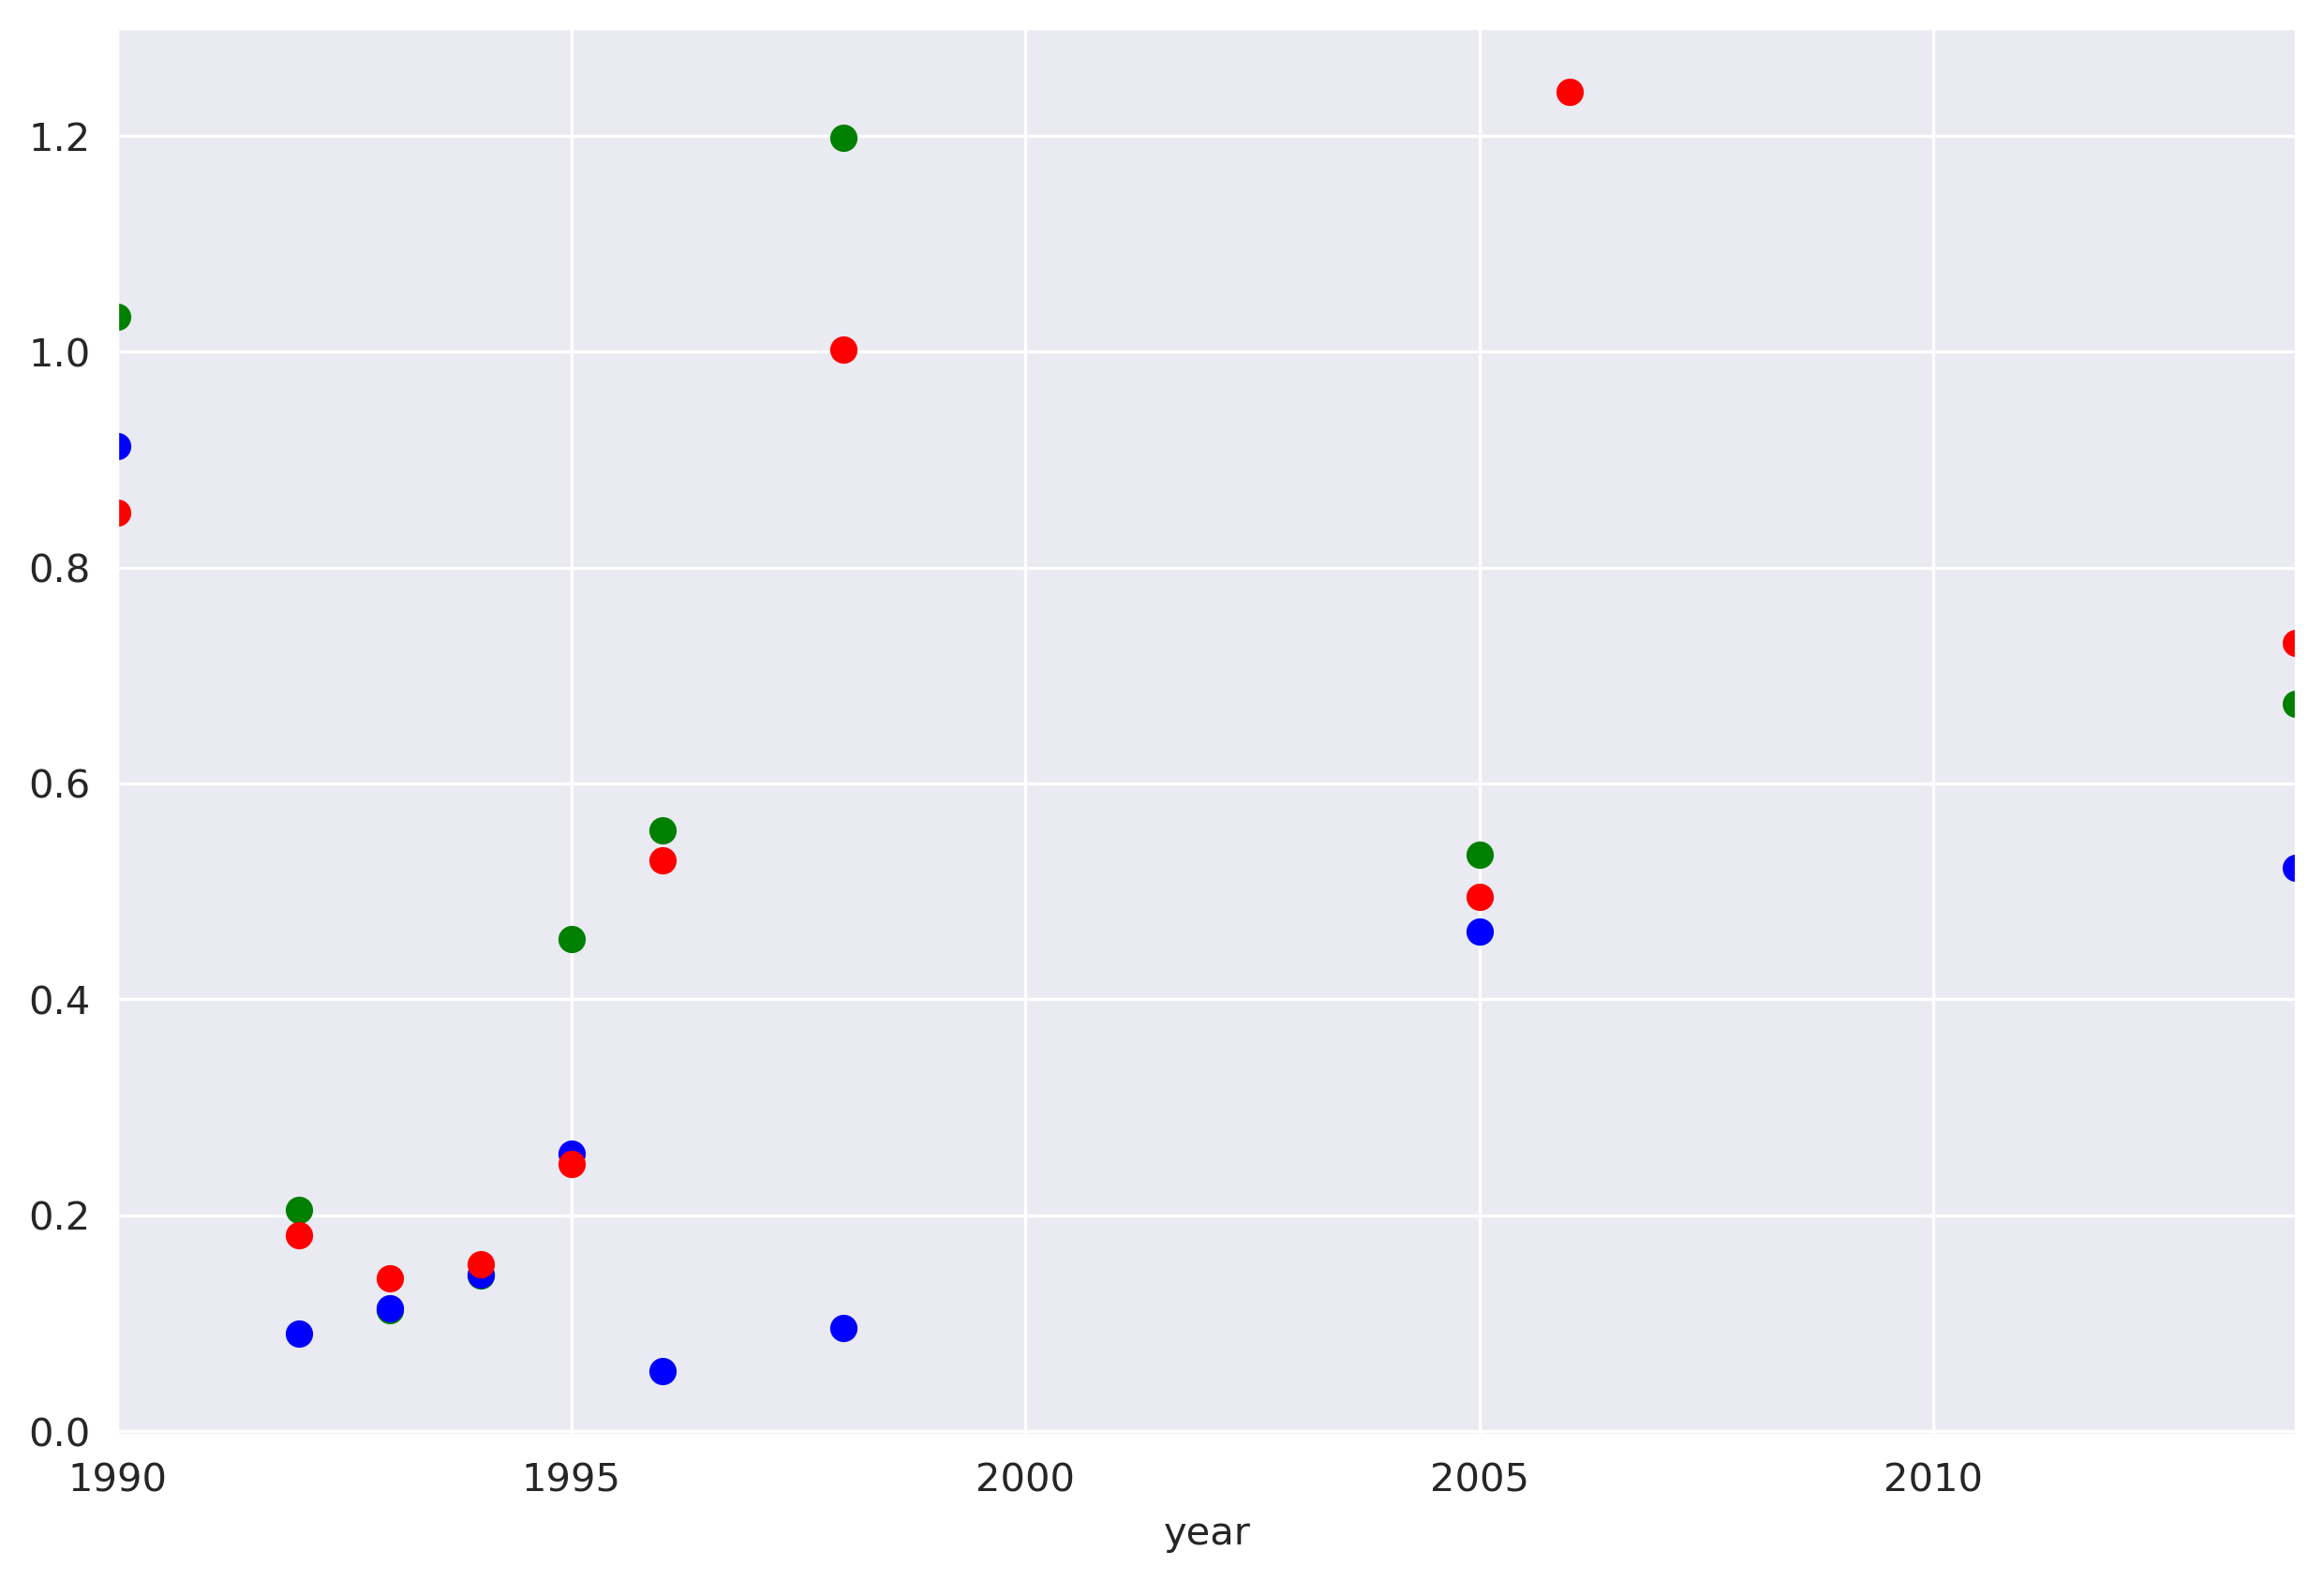

In [117]:
fig, ax = plt.subplots(figsize = (10, 6.5), sharey = True)

tracername = "CFC-11"
tmp1 = interp_ctrl_timeseries.cfc11 * variable_kwargs["cfc11"]["conversion"]
tmp1 = tmp1.where(tmp1 > 0)
tmp1.sel(z = slice(-4000, -6000)).mean("z").plot.scatter(ax = ax, color = "green")
ax.set_xlim(1990, 2014)
ax.set_title("Control CM4X 0.125° \n sampled like GLODAP\n using annual averages")

tmp2 = interp_hist_timeseries.cfc11  * variable_kwargs["cfc11"]["conversion"]
tmp2 = tmp2.where(tmp2 > 0)
tmp2.sel(z = slice(-4000, -6000)).mean("z").plot.scatter(ax = ax, color = "blue")

# cm = ax[1].pcolormesh(interp_hist_timeseries.year, tmp2.z, tmp2, vmax = 1.5, vmin = 1e-2, cmap = cmo.matter_r)

# ax[1].set_xlim(1990, 2014)
# ax[1].set_title("Historical CM4X 0.125° \n sampled like GLODAP\n using annual averages")

tmp3 = glodap_so_avg.T
tmp3 = tmp3.where(tmp3 > 0)
tmp3.sel(z = slice(4200, 6000)).mean("z").plot.scatter(ax = ax, color = "red")

# cm1 = ax[2].pcolormesh(tmp3.year, -tmp3.z, tmp3,  vmax = 1.5, vmin = 1e-2, cmap = cmo.matter_r)
# ax[2].set_xlim(1990, 2014)
# ax[2].set_title("GLODAP Observations")

# fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")
# fig.tight_layout()
# fig.colorbar(cm, ax = ax[0:3], label = "pmol /kg")

# for a in ax[0:3]:
#     a.set_xlabel("time [years]")
